In [1]:
import numpy as np
import pandas as pd

In [2]:
df = pd.read_csv("../data/drug200.csv")

# 데이터 전처리

In [3]:
df.head()

,Age,Sex,BP,Cholesterol,Na_to_K,Drug
0,23,F,HIGH,HIGH,25.355,DrugY
1,47,M,LOW,HIGH,13.093,drugC
2,47,M,LOW,HIGH,10.114,drugC
3,28,F,NORMAL,HIGH,7.798,drugX
4,61,F,LOW,HIGH,18.043,DrugY


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Age          200 non-null    int64  
 1   Sex          200 non-null    object 
 2   BP           200 non-null    object 
 3   Cholesterol  200 non-null    object 
 4   Na_to_K      200 non-null    float64
 5   Drug         200 non-null    object 
dtypes: float64(1), int64(1), object(4)
memory usage: 9.5+ KB


## Sex

In [5]:
df['Sex'].value_counts()

Sex
M    104
F     96
Name: count, dtype: int64

In [6]:
df = pd.concat([df, pd.get_dummies(df['Sex'], dtype=int)], axis=1)

df.drop(columns='Sex', axis=1, inplace=True)

## BP

In [7]:
df['BP'].value_counts()

BP
HIGH      77
LOW       64
NORMAL    59
Name: count, dtype: int64

In [8]:
df = pd.concat([df, pd.get_dummies(df['BP'], dtype=int)], axis=1)

df.drop(columns='BP', axis=1, inplace=True)

## Cholesterol

In [9]:
df['Cholesterol'].value_counts()

Cholesterol
HIGH      103
NORMAL     97
Name: count, dtype: int64

In [10]:
df = pd.concat([df, pd.get_dummies(df['Cholesterol'], dtype=int)], axis=1)

df.drop(columns='Cholesterol', axis=1, inplace=True)

# Drug

In [11]:
df['Drug'].value_counts()

Drug
DrugY    91
drugX    54
drugA    23
drugC    16
drugB    16
Name: count, dtype: int64

In [12]:
from sklearn.preprocessing import LabelEncoder

In [13]:
le = LabelEncoder()
df['Drug'] = le.fit_transform(df['Drug'])

In [14]:
le.classes_

array(['DrugY', 'drugA', 'drugB', 'drugC', 'drugX'], dtype=object)

---

# 데이터 학습

In [15]:
X = df.drop(columns='Drug', axis=1)
y = df['Drug']

In [16]:
from sklearn.model_selection import train_test_split

In [17]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [18]:
x_val = x_train[:40]
x_train = x_train[40:]
y_val = y_train[:40]
y_train = y_train[40:]

In [19]:
x_train = x_train.values
y_train = y_train.values
x_val = x_val.values
y_val = y_val.values
x_test = x_test.values
y_test = y_test.values

In [20]:
print(x_train.shape, y_train.shape, x_val.shape, y_val.shape, x_test.shape, y_test.shape)

(100, 9) (100,) (40, 9) (40,) (60, 9) (60,)


In [21]:
from collections import OrderedDict

In [22]:
from function import *

In [23]:
class MultiLayerNetExtend:
    def __init__(self, input_size, hidden_size_list, output_size):
        self.input_size = input_size
        self.output_size = output_size
        self.hidden_size_list = hidden_size_list
        self.hidden_layer_num = len(hidden_size_list)

        self.params = {}

        # 가중치 초기화
        self.__init_weight()

        # 계층 생성
        self.layers = OrderedDict()

        for idx in range(1, self.hidden_layer_num+1):
            self.layers['Affine' + str(idx)] = Affine(self.params['W' + str(idx)],
                                                      self.params['b' + str(idx)])
            self.layers['Activation_function' + str(idx)] = Relu()

        idx = self.hidden_layer_num + 1
        self.layers['Affine' + str(idx)] = Affine(self.params['W' + str(idx)], self.params['b' + str(idx)])

        self.last_layer = SoftmaxWithLoss()

    def __init_weight(self):
        all_size_list = [self.input_size] + self.hidden_size_list + [self.output_size]
        for idx in range(1, len(all_size_list)):
            scale = np.sqrt(2.0 / all_size_list[idx - 1])  # ReLU
            self.params['W' + str(idx)] = scale * np.random.randn(all_size_list[idx-1], all_size_list[idx])
            self.params['b' + str(idx)] = np.zeros(all_size_list[idx])
    def predict(self, x):
        for key, layer in self.layers.items():
            x = layer.forward(x)
            
        return x
    def loss(self, x, t):
        y = self.predict(x)

        weight_decay = 0
        for idx in range(1, self.hidden_layer_num + 2):
            W = self.params['W' + str(idx)]
            # weight_decay += 0.5 * self.weight_decay_lambda * np.sum(W**2)

        return self.last_layer.forward(y, t) # + weight_decay
        
    def accuracy(self, X, T):
        Y = self.predict(X)
        Y = np.argmax(Y, axis=1)
        if T.ndim != 1 : T = np.argmax(T, axis=1)

        accuracy = np.sum(Y == T) / float(X.shape[0])
        return accuracy
        
    def numerical_gradient(self, X, T):
        loss_W = lambda W: self.loss(X, T)

        grads = {}
        for idx in range(1, self.hidden_layer_num+2):
            grads['W' + str(idx)] = numerical_gradient(loss_W, self.params['W' + str(idx)])
            grads['b' + str(idx)] = numerical_gradient(loss_W, self.params['b' + str(idx)])

        return grads
        
    def gradient(self, x, t):
        # forward
        self.loss(x, t)

        # backward
        dout = 1
        dout = self.last_layer.backward(dout)

        layers = list(self.layers.values())
        layers.reverse()
        for layer in layers:
            dout = layer.backward(dout)

        # 결과 저장
        grads = {}
        for idx in range(1, self.hidden_layer_num+2):
            grads['W' + str(idx)] = self.layers['Affine' + str(idx)].dW # + self.weight_decay_lambda * self.params['W' + str(idx)]
            grads['b' + str(idx)] = self.layers['Affine' + str(idx)].db
            
        return grads

In [24]:
net = MultiLayerNetExtend(9, [10,10,10], 5)
optimizer = Adam()

In [25]:
train_loss_list = []
train_acc_list = []
test_acc_list = []

In [26]:
from tqdm import tqdm

In [27]:
for i in tqdm(range(1000)):

    grad = net.gradient(x_train, y_train)
    params = net.params

    optimizer.update(params, grad)

    loss = net.loss(x_train, y_train)
    train_loss_list.append(loss)

    if i % 10 == 0:
        train_acc = net.accuracy(x_train, y_train)
        test_acc = net.accuracy(x_test, y_test)
        train_acc_list.append(train_acc)
        test_acc_list.append(test_acc)

100%|████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 3691.29it/s]


In [28]:
import matplotlib.pyplot as plt

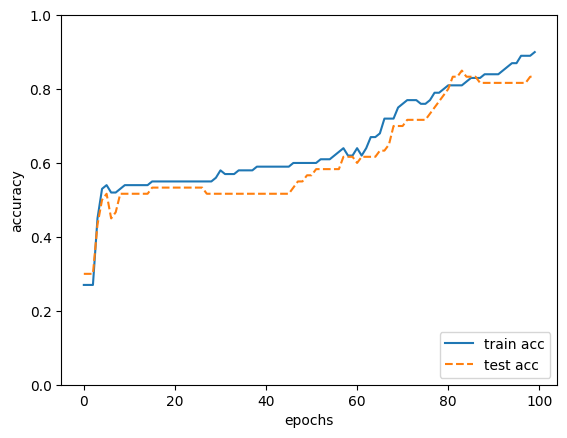

In [29]:
markers = {'train': 'o', 'test': 's'}
x = np.arange(len(train_acc_list))
plt.plot(x, train_acc_list, label='train acc')
plt.plot(x, test_acc_list, label='test acc', linestyle='--')
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.ylim(0, 1.0)
plt.legend(loc='lower right')
plt.show()